<a href="https://colab.research.google.com/github/dancoster/DrugLab/blob/dev/src/Medication-Trend/Regression_Medication_Labtest_Pairs_Retrieval_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medication-Labtest Pairs Retieval and T-Test P-values

## Import Libraries

In [ ]:
import pandas as pd
import datetime
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, metrics

## Load Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PARENT='/content/drive/MyDrive/TAU'
DATA = PARENT+'/Datasets/mimiciii/1.4'

In [ ]:
RESULT = PARENT+'/Results'

In [ ]:
for i in os.walk(os.path.join(DATA)):
    print(i)

('/content/drive/MyDrive/TAU/Datasets/mimiciii/1.4', [], ['CALLOUT.csv.gz', 'ADMISSIONS.csv.gz', 'CAREGIVERS.csv.gz', 'D_ITEMS.csv.gz', 'D_ICD_PROCEDURES.csv.gz', 'D_ICD_DIAGNOSES.csv.gz', 'ICUSTAYS.csv.gz', 'CHARTEVENTS.csv.gz', 'DRGCODES.csv.gz', 'CPTEVENTS.csv.gz', 'DIAGNOSES_ICD.csv.gz', 'D_CPT.csv.gz', 'D_LABITEMS.csv.gz', 'DATETIMEEVENTS.csv.gz', 'INPUTEVENTS_CV.csv.gz', 'INPUTEVENTS_MV.csv.gz', 'LABEVENTS.csv.gz', 'MICROBIOLOGYEVENTS.csv.gz', 'OUTPUTEVENTS.csv.gz', 'PATIENTS.csv.gz', 'README.md', 'PROCEDURES_ICD.csv.gz', 'PRESCRIPTIONS.csv.gz', 'TRANSFERS.csv.gz', 'PROCEDUREEVENTS_MV.csv.gz', 'SERVICES.csv.gz', 'LICENSE.txt', 'NOTEEVENTS.csv.gz', 'SHA256SUMS.txt', 'index.html'])


## Load Data

### Admissions

In [ ]:
admissions = pd.read_csv(os.path.join(DATA, 'ADMISSIONS.csv.gz'))

In [ ]:
# subject_id,hadm_id
admissions = admissions[['SUBJECT_ID', 'HADM_ID']]
admissions

,SUBJECT_ID,HADM_ID
0,22,165315
1,23,152223
2,23,124321
3,24,161859
4,25,129635
...,...,...
58971,98800,191113
58972,98802,101071
58973,98805,122631
58974,98813,170407


### Labevents

In [ ]:
labevents = pd.read_csv(os.path.join(DATA, 'LABEVENTS.csv.gz')).dropna()
d_labitems = pd.read_csv(os.path.join(DATA, 'D_LABITEMS.csv.gz')).dropna()

In [ ]:
labevents.shape, d_labitems.shape

((7881769, 9), (585, 6))

In [ ]:
labevents

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
162,443,3,145834.0,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal
163,444,3,145834.0,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal
166,447,3,145834.0,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal
169,450,3,145834.0,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal
170,451,3,145834.0,50971,2101-10-20 16:40:00,5.4,5.4,mEq/L,abnormal
...,...,...,...,...,...,...,...,...,...
27854045,27428430,96443,103219.0,50862,2109-12-30 01:40:00,2.2,2.2,g/dL,abnormal
27854046,27428431,96443,103219.0,50863,2109-12-30 01:40:00,172,172.0,IU/L,abnormal
27854049,27428434,96443,103219.0,50878,2109-12-30 01:40:00,467,467.0,IU/L,abnormal
27854051,27428436,96443,103219.0,50885,2109-12-30 01:40:00,2.1,2.1,mg/dL,abnormal


In [ ]:
labValues = pd.merge(labevents, d_labitems, on='ITEMID', how='inner')

In [ ]:
labValues.shape

(7876570, 14)

In [ ]:
# subject_id,l.hadm_id, d.label, l.valuenum, l.valueuom, l.charttime
labValues = labValues[['SUBJECT_ID', 'HADM_ID', 'LABEL', 'VALUENUM', 'VALUEUOM', 'CHARTTIME']]

In [ ]:
labValues['CHARTTIME'] = pd.to_datetime(labValues['CHARTTIME'],  format='%Y/%m/%d %H:%M:%S')

In [ ]:
labValues

,SUBJECT_ID,HADM_ID,LABEL,VALUENUM,VALUEUOM,CHARTTIME
0,3,145834.0,"Calcium, Total",8.2,mg/dL,2101-10-20 16:40:00
1,3,145834.0,"Calcium, Total",7.6,mg/dL,2101-10-22 04:00:00
2,3,145834.0,"Calcium, Total",7.1,mg/dL,2101-10-22 21:15:00
3,3,145834.0,"Calcium, Total",7.5,mg/dL,2101-10-23 03:45:00
4,3,145834.0,"Calcium, Total",7.4,mg/dL,2101-10-20 19:59:00
...,...,...,...,...,...,...
7876565,53160,138843.0,Plasma,1.0,%,2194-06-27 13:52:00
7876566,96240,168044.0,Plasma,7.0,%,2105-05-16 16:45:00
7876567,40200,108146.0,Sex Hormone Binding Globulin,12.0,nmol/L,2165-01-10 16:00:00
7876568,58010,185994.0,Sex Hormone Binding Globulin,11.0,nmol/L,2109-02-19 00:16:00


In [ ]:
del labevents, d_labitems

## Data Preprocessing

In [ ]:
def remove_multiple_admissions(df):
    """
    Removes hospital admissions that occur more than once for the same patient
  
    Parameters:
    df (DataFrame): Takes in dataframe with multiple hospital admissions
  
    Returns:
    Dataframe: Returns dataframe with multiple hospital admissions removed
    """
    first_admissions = admissions
    first_admissions = first_admissions.drop_duplicates(subset=['SUBJECT_ID'], keep='first')
    df = df[df['HADM_ID'].isin(first_admissions['HADM_ID'])]
    return df

In [ ]:
lab_measurements = labValues

In [ ]:
len(list(lab_measurements['SUBJECT_ID'].value_counts().keys()))

45861

In [ ]:
import random
subjects_2k = random.sample(list(lab_measurements['SUBJECT_ID'].value_counts().keys()), 10000)

In [ ]:
inputevents_mv = pd.read_csv(os.path.join(DATA, 'INPUTEVENTS_MV.csv.gz'), nrows=10)

In [ ]:
inputevents_mv.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME',
       'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'RATE', 'RATEUOM', 'STORETIME', 'CGID',
       'ORDERID', 'LINKORDERID', 'ORDERCATEGORYNAME',
       'SECONDARYORDERCATEGORYNAME', 'ORDERCOMPONENTTYPEDESCRIPTION',
       'ORDERCATEGORYDESCRIPTION', 'PATIENTWEIGHT', 'TOTALAMOUNT',
       'TOTALAMOUNTUOM', 'ISOPENBAG', 'CONTINUEINNEXTDEPT', 'CANCELREASON',
       'STATUSDESCRIPTION', 'COMMENTS_EDITEDBY', 'COMMENTS_CANCELEDBY',
       'COMMENTS_DATE', 'ORIGINALAMOUNT', 'ORIGINALRATE'],
      dtype='object')

In [ ]:
import gzip
import csv
from tqdm import tqdm

with gzip.open(os.path.join(DATA, 'INPUTEVENTS_MV.csv.gz'), 'rb') as fp:
    for i, k in enumerate(fp):
        pass
size = i+1
# size of input events is 3618992

In [ ]:
data = []
headers = None
with gzip.open(os.path.join(DATA, 'INPUTEVENTS_MV.csv.gz'), 'rt') as fp:
    reader = csv.reader(fp)
    headers = next(reader)
    for line in tqdm(reader, total=size):
        if int(line[1]) in subjects_2k and line[-6]=="FinishedRunning" and line[-7]=='0':
            data.append(line)

100%|█████████▉| 3618991/3618992 [14:21<00:00, 4202.92it/s]


In [ ]:
inputevents_mv_subjects = pd.DataFrame(data, columns=headers)

In [ ]:
inputevents_mv_subjects.shape

(447455, 31)

In [ ]:
for i in ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID']:
    print(i)
    inputevents_mv_subjects[i] = inputevents_mv_subjects[i].astype('int64')

ROW_ID
SUBJECT_ID
HADM_ID
ITEMID


In [ ]:
d_item = pd.read_csv(os.path.join(DATA, 'D_ITEMS.csv.gz'))

In [ ]:
ditem_inputevents_mv = pd.merge(inputevents_mv_subjects, d_item, on='ITEMID', how='inner')

In [ ]:
inputevents_mv_1 = ditem_inputevents_mv[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'STARTTIME', 'ENDTIME', 'ITEMID', 'AMOUNT', 'AMOUNTUOM', 'UNITNAME', 'ORDERCATEGORYNAME', 'LABEL', 'CATEGORY', 'PARAM_TYPE']]
inputevents_mv_1

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,UNITNAME,ORDERCATEGORYNAME,LABEL,CATEGORY,PARAM_TYPE
0,23792,150835,227602,2106-12-14 14:16:00,2106-12-14 14:17:00,226452,60,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
1,23792,150835,227602,2106-12-14 17:37:00,2106-12-14 17:38:00,226452,180,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
2,23792,150835,227602,2106-12-14 11:00:00,2106-12-14 11:01:00,226452,120,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
3,23792,150835,227602,2106-12-14 13:00:00,2106-12-14 13:01:00,226452,240,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
4,12567,154592,247932,2204-12-29 16:00:00,2204-12-29 16:01:00,226452,100,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447450,78431,146452,218641,2201-03-28 09:27:00,2201-03-28 09:28:00,225995,120,ml,mL,15-Supplements,Mighty Shake (Chocolate),Nutrition - Supplements,Solution
447451,78431,146452,218641,2201-03-28 12:53:00,2201-03-28 12:54:00,225995,80,ml,mL,15-Supplements,Mighty Shake (Chocolate),Nutrition - Supplements,Solution
447452,78431,146452,218641,2201-03-27 09:00:00,2201-03-27 09:01:00,225995,30,ml,mL,15-Supplements,Mighty Shake (Chocolate),Nutrition - Supplements,Solution
447453,78431,146452,218641,2201-03-27 14:36:00,2201-03-27 14:37:00,225995,100,ml,mL,15-Supplements,Mighty Shake (Chocolate),Nutrition - Supplements,Solution


In [ ]:
top200_meds = inputevents_mv_1['LABEL'].value_counts()[:200]

In [ ]:
top200_meds

Dextrose 5%                 52569
NaCl 0.9%                   32176
PO Intake                   29004
Gastric Meds                21272
Solution                    18334
                            ...  
Cyclosporine                   12
Replete (1/2)                  12
Replete with Fiber (1/4)       11
Nutren Pulmonary (1/2)         11
Argatroban                     11
Name: LABEL, Length: 200, dtype: int64

In [ ]:
inputevents_mv_1['STARTTIME'] = pd.to_datetime(inputevents_mv_1['STARTTIME'],  format='%Y/%m/%d %H:%M:%S')
inputevents_mv_1['ENDTIME'] = pd.to_datetime(inputevents_mv_1['ENDTIME'],  format='%Y/%m/%d %H:%M:%S')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
top200_meds = pd.DataFrame(top200_meds, columns=['LABEL']).reset_index()
top200_meds.rename(columns = {'index':'MED', 'LABEL':'COUNT'}, inplace = True)
top200_meds

,MED,COUNT
0,Dextrose 5%,52569
1,NaCl 0.9%,32176
2,PO Intake,29004
3,Gastric Meds,21272
4,Solution,18334
...,...,...
195,Cyclosporine,12
196,Replete (1/2),12
197,Replete with Fiber (1/4),11
198,Nutren Pulmonary (1/2),11


In [ ]:
patient_presc = inputevents_mv_1

In [ ]:
patient_presc = remove_multiple_admissions(patient_presc)
patient_presc = inputevents_mv_1[inputevents_mv_1['LABEL'].isin(top200_meds['MED'])]

In [ ]:
patient_presc

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTTIME,ENDTIME,ITEMID,AMOUNT,AMOUNTUOM,UNITNAME,ORDERCATEGORYNAME,LABEL,CATEGORY,PARAM_TYPE
0,23792,150835,227602,2106-12-14 14:16:00,2106-12-14 14:17:00,226452,60,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
1,23792,150835,227602,2106-12-14 17:37:00,2106-12-14 17:38:00,226452,180,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
2,23792,150835,227602,2106-12-14 11:00:00,2106-12-14 11:01:00,226452,120,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
3,23792,150835,227602,2106-12-14 13:00:00,2106-12-14 13:01:00,226452,240,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
4,12567,154592,247932,2204-12-29 16:00:00,2204-12-29 16:01:00,226452,100,ml,mL,14-Oral/Gastric Intake,PO Intake,Fluids/Intake,Solution
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447434,70226,114222,278448,2181-09-28 14:32:00,2181-09-29 04:41:00,228351,500.00000784,ml,mL,13-Enteral Nutrition,Nepro (Full),Nutrition - Enteral,Solution
447435,70226,114222,278448,2181-09-29 18:57:00,2181-09-30 09:06:00,228351,500.00000784,ml,mL,13-Enteral Nutrition,Nepro (Full),Nutrition - Enteral,Solution
447436,70226,114222,278448,2181-09-30 09:06:00,2181-09-30 23:23:00,228351,499.89999516,ml,mL,13-Enteral Nutrition,Nepro (Full),Nutrition - Enteral,Solution
447437,70226,114222,278448,2181-10-02 03:53:00,2181-10-02 18:07:00,228351,498.1999869,ml,mL,13-Enteral Nutrition,Nepro (Full),Nutrition - Enteral,Solution


In [ ]:
lab_measurements = lab_measurements[lab_measurements.duplicated(subset=['SUBJECT_ID','LABEL'],keep=False)]

In [ ]:
lab_measurements = lab_measurements[lab_measurements['HADM_ID'].isin(patient_presc['HADM_ID'])]

In [ ]:
lab_measurements

,SUBJECT_ID,HADM_ID,LABEL,VALUENUM,VALUEUOM,CHARTTIME
131,36,165660.0,"Calcium, Total",7.7,mg/dL,2134-05-16 03:02:00
132,36,165660.0,"Calcium, Total",8.3,mg/dL,2134-05-17 05:45:00
133,36,165660.0,"Calcium, Total",8.0,mg/dL,2134-05-18 07:05:00
138,36,165660.0,"Calcium, Total",8.0,mg/dL,2134-05-11 05:15:00
139,36,165660.0,"Calcium, Total",8.3,mg/dL,2134-05-11 18:00:00
...,...,...,...,...,...,...
7876377,91511,122509.0,Von Willebrand Factor Antigen,280.0,%,2118-05-29 05:22:00
7876378,91511,184851.0,Von Willebrand Factor Antigen,232.0,%,2118-06-04 04:32:00
7876553,79575,127630.0,"Tissue Transglutaminase Ab, IgA",32.0,units,2194-09-19 03:00:00
7876554,79575,127630.0,"Tissue Transglutaminase Ab, IgA",34.0,units,2194-10-05 09:10:00


## Generating Lab Test<>Meds Pairings

In [ ]:
def labpairing(medname, prescdf, labdf, labname):
    """Pairs the drug input with each lab test

    Parameters:
    drugname (String): Drug Name
    prescdf (DataFrame): Dataframe containing the prescription data
    labdf (DataFrame): Dataframe containing the lab measurement data
    labname (DataFrame): Lab Test Name
    Returns:
    DataFrame: Contains all the rows of values and times for that particular drug lab apir
  
    """
    # Select patients who have taken the drug
    prescdf = prescdf[prescdf['LABEL']==medname]
    prescdf = prescdf.drop_duplicates(subset=['SUBJECT_ID'], keep='first')

    # Select lab measurements of patients who have taken the drug
    labdf = labdf[labdf['HADM_ID'].isin(prescdf['HADM_ID'])]

    # Selects the lab measurement entered
    drug_lab_specific = labdf[labdf['LABEL']==labname]
    mergeddf = pd.merge(drug_lab_specific, prescdf, on=['HADM_ID','SUBJECT_ID'])

    # Get time from prescription and choose before and after lab measurements (within 24hrs=1day)
    mergeddf['timeFromPrescription'] = mergeddf['CHARTTIME'] - mergeddf['STARTTIME']
    posmergeddf = mergeddf.loc[mergeddf.timeFromPrescription > datetime.timedelta(days=0)]
    negmergeddf = mergeddf.loc[mergeddf.timeFromPrescription < datetime.timedelta(days=0)]
    
    # Only keep values for which we have both before and after
    posmergeddf = posmergeddf[posmergeddf['HADM_ID'].isin(negmergeddf['HADM_ID'])]
    negmergeddf = negmergeddf[negmergeddf['HADM_ID'].isin(posmergeddf['HADM_ID'])]

    # Choose admissions which have more than one lab test reading
    before = posmergeddf
    bool_before = before.groupby('SUBJECT_ID').count()>1
    index_before = bool_before[bool_before['HADM_ID']==True].index
    before = posmergeddf[posmergeddf['SUBJECT_ID'].isin(index_before)]
    posmergeddf = posmergeddf.loc[posmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmin()]

    after = negmergeddf
    bool_after = after.groupby('SUBJECT_ID').count()>1
    index_after = bool_after[bool_after['HADM_ID']==True].index
    after = after[after['SUBJECT_ID'].isin(index_after)]
    negmergeddf = negmergeddf.loc[negmergeddf.groupby('SUBJECT_ID').timeFromPrescription.idxmax()]

    before = before[before['HADM_ID'].isin(after['HADM_ID'])]
    after = after[after['HADM_ID'].isin(before['HADM_ID'])]

    finaldf = negmergeddf.merge(posmergeddf,on=['HADM_ID','SUBJECT_ID'])
    
    return finaldf, before, after

In [ ]:
# finalDF, before, after = labpairing('NaCl 0.9%', patient_presc, lab_measurements, 'Calcium, Total')

## Regression Analysis

In [ ]:
def get_min(col):
    return col.apply(lambda td : td.total_seconds()//60)

def get_hour(col):
    return col.apply(lambda td : td.total_seconds()//3600)

In [ ]:
# Regression Analysis
def gen_estimate_coef(subjects, before, verbose=False):
    reg_anal_res = []
    lab_vals = []
    time = []

    for i in subjects:
        
        res_vals = dict()
        res_vals['subjectID'] = i
        
        rows = before[before['SUBJECT_ID']==i]
        rows = rows.sort_values(by='timeFromPrescription')

        x = rows['VALUENUM']
        y = get_min(rows['timeFromPrescription'])

        reg = linear_model.LinearRegression()
        reg.fit(np.array(y).reshape(-1,1), np.array(x).reshape(-1,1))

        res_vals['coef'] = reg.coef_[0][0]
        res_vals['estimated'] = reg.predict([[0]])[0][0]
        
        if verbose:
            print('Subject ID: ', i, '  Coefficients: ', reg.coef_)

        reg_anal_res.append(res_vals)

        lab_vals.append(x)
        time.append(y) 

    return reg_anal_res, lab_vals, time

## Time VS Labtest Value Plots

In [ ]:
def gen_plot_data(subjects, before_time, after_time, before_lab_vals, after_lab_vals):
    res = []
    for i, subject in enumerate(subjects):

        # Handling time
        x1 = list(before_time[i])
        before = list(map(lambda t: -1*t, x1))
        x2 = list(after_time[i])
        after = list(map(lambda t: -1*t, x2))
        before.reverse()
        after.reverse()
        before.extend(after)
        x = before

        # Handling labtest values
        y1 = list(before_lab_vals[i])
        y1.reverse()
        y2 = list(after_lab_vals[i])
        y2.reverse()
        y1.extend(y2)
        y = y1

        res.append([subject, x, y])
    
    return res

In [ ]:
# res_data = gen_plot_data(subjects, before_time, after_time, before_lab_vals, after_lab_vals)

In [ ]:
def plot_graph(res, limits=(0,1), title=None, units=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(limits[0], limits[1]):
        ax.plot(res[i][1], res[i][2], label = "Subject "+str(res[i][0]), linestyle="-")
        ax.legend()
    ax.spines['right'].set_position('zero')
    plt.xlim(-1500,1500)
    plt.xlabel('Time After Medication in Hours')
    if units:
        plt.ylabel('Lab Values in '+units)
    if title:
        plt.title(title)
    else:
        plt.title('Time VS Lab Test Values')
    plt.savefig(os.path.join(PARENT, 'Plots', title+'.png'))

In [ ]:
# plot_graph(res_data, (5,10))

## Final Analysis Functions -Ttest
Results Generation

In [ ]:
def analysis_func(lab_measurements, top200_meds, n_medlab_pairs = 25, n_meds=None):
    res = pd.DataFrame(columns=['Medication','Lab Test','Number of patients','Estimated (mean)','Estimated (std)', 'Feature After(mean)','Feature After(std)','Time After(mean)','Time After(std)','Mannwhitney-pvalue','Ttest-pvalue'])
    uniqueLabTests = lab_measurements.LABEL.unique()
    final_res = []
    after_vals = []

    for i, med in enumerate(top200_meds['MED']): 
        if n_meds is not None and i>=n_meds:
            break
        print(i, ' MED: ', med)
        for j in tqdm(range(uniqueLabTests.shape[0])):
            labTest = uniqueLabTests[j]
            drug_lab, before, after = labpairing(med, patient_presc, lab_measurements, labTest)
            subjects = before['SUBJECT_ID'].unique()
            if(len(before) > n_medlab_pairs):
                before_reg_anal_res, before_lab_vals, before_time = gen_estimate_coef(subjects, before)
                after_reg_anal_res, after_lab_vals, after_time = gen_estimate_coef(subjects, after)
                estimated = np.array(pd.DataFrame(after_reg_anal_res)['estimated'])
                after_values = np.array([k.mean() for k in after_lab_vals])
                ttest_res = stats.ttest_ind(estimated, after_values)[1]
                final_res.append([med, labTest, ttest_res, np.mean(estimated), np.std(estimated), np.mean(after_values), np.std(after_values), np.mean(-1*np.array([k.mean() for k in after_time])), np.std(-1*np.array([k.mean() for k in after_time])), len(before)])
    return pd.DataFrame(final_res, columns=['Medication','Lab Test','Ttest-pvalue','Estimated (mean)','Estimated (std)', 'Feature After(mean)','Feature After(std)','Time After(mean)','Time After(std)','Number of patients']), after_vals

In [ ]:
# result_final_df

,Medication,Lab Test,Ttest-pvalue,Estimated (mean),Estimated (std),Feature After(mean),Feature After(std),Time After(mean),Time After(std),Number of patients
0,Dextrose 5%,"Calcium, Total",1.581442e-01,7.902228,2.003336,7.835962,0.795105,5390.341786,6944.797231,22362
1,Dextrose 5%,Chloride,1.090673e-01,107.796944,16.568219,106.989329,9.462127,5941.261105,7533.691012,12401
2,Dextrose 5%,Creatinine,5.257812e-02,2.591746,2.766439,2.745357,2.125223,4903.200801,6349.560796,25754
3,Dextrose 5%,Phosphate,7.546138e-04,3.610398,2.719946,3.866643,1.798569,5946.340199,7065.997230,14843
4,Dextrose 5%,Potassium,2.950199e-02,2.344691,20.612009,4.366184,1.300948,7522.906546,9324.865175,2438
5,Dextrose 5%,Asparate Aminotransferase (AST),3.039851e-02,383.993576,1490.604274,527.737783,1285.141390,5549.079995,6595.688534,7821
6,Dextrose 5%,Bicarbonate,2.068434e-04,22.947357,14.478929,21.358456,6.892121,5682.364583,8237.167409,11771
7,Dextrose 5%,Glucose,5.612737e-09,136.976879,189.652798,156.546986,52.185602,5027.421589,5842.076785,47428
8,Dextrose 5%,Urea Nitrogen,1.961837e-01,42.022403,29.972094,42.983134,23.107749,5076.049392,6207.390751,34663
9,Dextrose 5%,Hematocrit,3.709000e-29,28.050671,7.248666,29.570805,3.646528,4984.314829,5898.772931,56000


In [ ]:
top200_meds[:60]

,MED,COUNT
0,Dextrose 5%,52569
1,NaCl 0.9%,32176
2,PO Intake,29004
3,Gastric Meds,21272
4,Solution,18334
5,Heparin Sodium (Prophylaxis),16318
6,Fentanyl,14861
7,Insulin - Regular,14823
8,Potassium Chloride,13526
9,GT Flush,13096


In [ ]:
final_res_df, res_after_values = analysis_func(lab_measurements, top200_meds[:60], n_medlab_pairs = 1000)

0  MED:  Dextrose 5%


100%|██████████| 163/163 [04:00<00:00,  1.48s/it]


1  MED:  NaCl 0.9%


100%|██████████| 163/163 [03:41<00:00,  1.36s/it]


2  MED:  PO Intake


100%|██████████| 163/163 [03:00<00:00,  1.11s/it]


3  MED:  Gastric Meds


100%|██████████| 163/163 [02:11<00:00,  1.24it/s]


4  MED:  Solution


100%|██████████| 163/163 [02:57<00:00,  1.09s/it]


5  MED:  Heparin Sodium (Prophylaxis)


100%|██████████| 163/163 [02:27<00:00,  1.10it/s]


6  MED:  Fentanyl


100%|██████████| 163/163 [02:02<00:00,  1.33it/s]


7  MED:  Insulin - Regular


100%|██████████| 163/163 [02:19<00:00,  1.17it/s]


8  MED:  Potassium Chloride


100%|██████████| 163/163 [02:45<00:00,  1.01s/it]


9  MED:  GT Flush


100%|██████████| 163/163 [01:47<00:00,  1.52it/s]


10  MED:  Propofol


100%|██████████| 163/163 [01:53<00:00,  1.43it/s]


11  MED:  Vancomycin


100%|██████████| 163/163 [02:43<00:00,  1.00s/it]


12  MED:  Morphine Sulfate


100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


13  MED:  KCL (Bolus)


100%|██████████| 163/163 [02:02<00:00,  1.33it/s]


14  MED:  Midazolam (Versed)


100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


15  MED:  Metoprolol


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


16  MED:  Piggyback


100%|██████████| 163/163 [02:16<00:00,  1.19it/s]


17  MED:  Hydromorphone (Dilaudid)


100%|██████████| 163/163 [00:59<00:00,  2.73it/s]


18  MED:  Insulin - Humalog


100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


19  MED:  Furosemide (Lasix)


100%|██████████| 163/163 [02:12<00:00,  1.23it/s]


20  MED:  LR


100%|██████████| 163/163 [02:00<00:00,  1.35it/s]


21  MED:  Piperacillin/Tazobactam (Zosyn)


100%|██████████| 163/163 [01:20<00:00,  2.03it/s]


22  MED:  Magnesium Sulfate


100%|██████████| 163/163 [02:40<00:00,  1.02it/s]


23  MED:  Pantoprazole (Protonix)


100%|██████████| 163/163 [01:53<00:00,  1.44it/s]


24  MED:  Packed Red Blood Cells


100%|██████████| 163/163 [02:03<00:00,  1.33it/s]


25  MED:  Metronidazole


100%|██████████| 163/163 [01:05<00:00,  2.48it/s]


26  MED:  Famotidine (Pepcid)


100%|██████████| 163/163 [01:17<00:00,  2.12it/s]


27  MED:  Calcium Gluconate


100%|██████████| 163/163 [02:20<00:00,  1.16it/s]


28  MED:  Free Water


100%|██████████| 163/163 [00:48<00:00,  3.34it/s]


29  MED:  Sterile Water


100%|██████████| 163/163 [01:04<00:00,  2.53it/s]


30  MED:  Magnesium Sulfate (Bolus)


100%|██████████| 163/163 [02:15<00:00,  1.20it/s]


31  MED:  Lorazepam (Ativan)


100%|██████████| 163/163 [00:59<00:00,  2.75it/s]


32  MED:  Meropenem


100%|██████████| 163/163 [00:37<00:00,  4.35it/s]


33  MED:  Cefepime


100%|██████████| 163/163 [00:59<00:00,  2.74it/s]


34  MED:  Cefazolin


100%|██████████| 163/163 [00:54<00:00,  3.00it/s]


35  MED:  Hydralazine


100%|██████████| 163/163 [00:56<00:00,  2.88it/s]


36  MED:  Ciprofloxacin


100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


37  MED:  Replete with Fiber (Full)


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


38  MED:  Albumin 25%


100%|██████████| 163/163 [00:51<00:00,  3.18it/s]


39  MED:  KCl (CRRT)


100%|██████████| 163/163 [00:25<00:00,  6.52it/s]


40  MED:  Insulin - Glargine


100%|██████████| 163/163 [00:52<00:00,  3.13it/s]


41  MED:  Norepinephrine


100%|██████████| 163/163 [00:56<00:00,  2.89it/s]


42  MED:  Phenylephrine


100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


43  MED:  Heparin Sodium


100%|██████████| 163/163 [00:52<00:00,  3.12it/s]


44  MED:  Fresh Frozen Plasma


100%|██████████| 163/163 [00:54<00:00,  2.99it/s]


45  MED:  Fentanyl (Concentrate)


100%|██████████| 163/163 [00:48<00:00,  3.33it/s]


46  MED:  OR Crystalloid Intake


100%|██████████| 163/163 [01:36<00:00,  1.68it/s]


47  MED:  Albumin 5%


100%|██████████| 163/163 [01:02<00:00,  2.62it/s]


48  MED:  Nafcillin


100%|██████████| 163/163 [00:16<00:00, 10.06it/s]


49  MED:  Citrate


100%|██████████| 163/163 [00:22<00:00,  7.36it/s]


50  MED:  ACD-A Citrate (1000ml)


100%|██████████| 163/163 [00:22<00:00,  7.35it/s]


51  MED:  D5 1/2NS


100%|██████████| 163/163 [00:49<00:00,  3.30it/s]


52  MED:  Pre-Admission Intake


100%|██████████| 163/163 [00:44<00:00,  3.69it/s]


53  MED:  Haloperidol (Haldol)


100%|██████████| 163/163 [00:33<00:00,  4.87it/s]


54  MED:  Dilantin


100%|██████████| 163/163 [00:21<00:00,  7.73it/s]


55  MED:  Piperacillin


100%|██████████| 163/163 [00:40<00:00,  4.00it/s]


56  MED:  Acyclovir


100%|██████████| 163/163 [00:21<00:00,  7.66it/s]


57  MED:  Beneprotein


100%|██████████| 163/163 [00:22<00:00,  7.22it/s]


58  MED:  Ceftriaxone


100%|██████████| 163/163 [00:40<00:00,  4.05it/s]


59  MED:  Labetalol


100%|██████████| 163/163 [00:23<00:00,  6.80it/s]


In [ ]:
final_res_df

,Medication,Lab Test,Ttest-pvalue,Estimated (mean),Estimated (std),Feature After(mean),Feature After(std),Time After(mean),Time After(std),Number of patients
0,Dextrose 5%,"Calcium, Total",0.623062,7.833035,1.348189,7.806308,0.739587,4119.951289,5653.278847,6377
1,Dextrose 5%,Chloride,0.239468,108.472083,13.440038,107.600239,9.450144,4519.163802,5963.001996,3660
2,Dextrose 5%,Creatinine,0.179051,2.502950,3.356789,2.708780,2.328687,4087.627951,5054.102963,7686
3,Dextrose 5%,Phosphate,0.056293,3.536708,2.803136,3.802750,1.938160,4985.209744,6205.658178,3854
4,Dextrose 5%,Asparate Aminotransferase (AST),0.137399,322.281036,1102.504233,462.868500,1060.103172,4723.115504,5723.705106,1976
...,...,...,...,...,...,...,...,...,...,...
1160,Ceftriaxone,pO2,0.330551,830.881757,6223.317605,124.620982,48.522098,3429.415014,4372.152806,1267
1161,Labetalol,Glucose,0.160730,145.827407,98.292075,158.902914,51.132912,4232.389886,5228.884798,1631
1162,Labetalol,Hematocrit,0.000559,28.931015,5.427553,31.042798,4.503288,4485.833859,6007.441176,1876
1163,Labetalol,Hemoglobin,0.000173,9.755980,2.001523,10.581540,1.574583,4569.295571,6120.806872,1739


In [ ]:
final_res_df.to_csv(os.path.join(RESULT, 'Final_res_with_selection.csv'))

## Plotting

In [ ]:
def gen_plot_time_units(subjects, before, verbose=False):
    reg_anal_res = []
    lab_vals = []
    time = []
    time_hour = []

    for i in subjects:
        
        res_vals = dict()
        res_vals['subjectID'] = i
        
        rows = before[before['SUBJECT_ID']==i]
        rows = rows.sort_values(by='timeFromPrescription')

        x = rows['VALUENUM']
        y = get_min(rows['timeFromPrescription'])

        reg = linear_model.LinearRegression()
        reg.fit(np.array(y).reshape(-1,1), np.array(x).reshape(-1,1))

        res_vals['coef'] = reg.coef_[0][0]
        res_vals['estimated'] = reg.predict([[0]])[0][0]
        
        if verbose:
            print('Subject ID: ', i, '  Coefficients: ', reg.coef_)

        reg_anal_res.append(res_vals)

        lab_vals.append(x)
        time.append(y) 
        time_hour.append(get_hour(rows['timeFromPrescription']))

    return reg_anal_res, lab_vals, time, rows['AMOUNTUOM'].unique()[0], time_hour

In [ ]:
def generate_final_plot_data(k, n):
    res = list()
    for i, row in tqdm(enumerate(k.iterrows()), total=n):
        if i>=n:
            break
        med = row[1]['Medication']
        labTest = row[1]['Lab Test']
        drug_lab, before, after = labpairing(med, patient_presc, lab_measurements, labTest)
        subjects = list(set(before['SUBJECT_ID'].value_counts().keys()[:100]).intersection(after['SUBJECT_ID'].value_counts().keys()[:100]))
        if len(subjects_2k)>10:
            subjects = subjects[:10]
        before_reg_anal_res, before_lab_vals, before_time, unit1, before_time_hr = gen_plot_time_units(subjects, before)
        after_reg_anal_res, after_lab_vals, after_time, unit2, after_time_hr = gen_plot_time_units(subjects, after)
        res.append({
            'med' : med,
            'test': labTest,
            'subjects':subjects,
            'before': (before_lab_vals, before_time_hr, unit1),
            'after': (after_lab_vals, after_time_hr, unit2)
        })
    return res

In [ ]:
def plot_med_lab_pairs(res):
    for val in res:
        if val['before'][2]==val['after'][2]:
            d = gen_plot_data(
                val['subjects'], 
                val['before'][1], 
                val['after'][1], 
                val['before'][0], 
                val['after'][0]
            )
            plot_graph(d, (0,10), 
                title=val['med']+'<>'+val['test'], 
                units=val['before'][2])

In [ ]:
significant_pairs = final_res_df.sort_values(by='Ttest-pvalue')[:100].sort_values(by='Number of patients', ascending=False)
non_significant_pairs = final_res_df[final_res_df['Ttest-pvalue']>0.05].sort_values(by='Ttest-pvalue')[:100].sort_values(by='Number of patients', ascending=False)

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


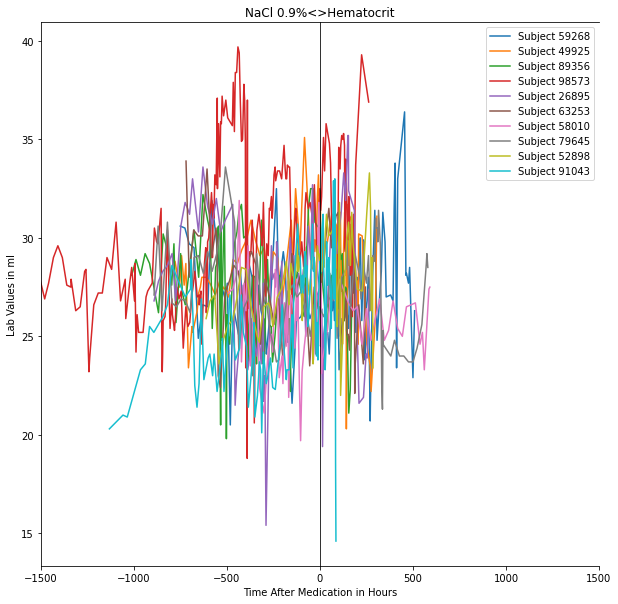

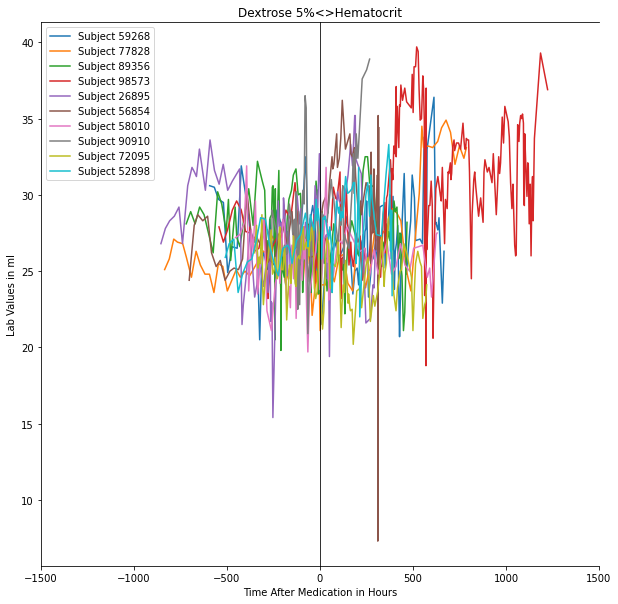

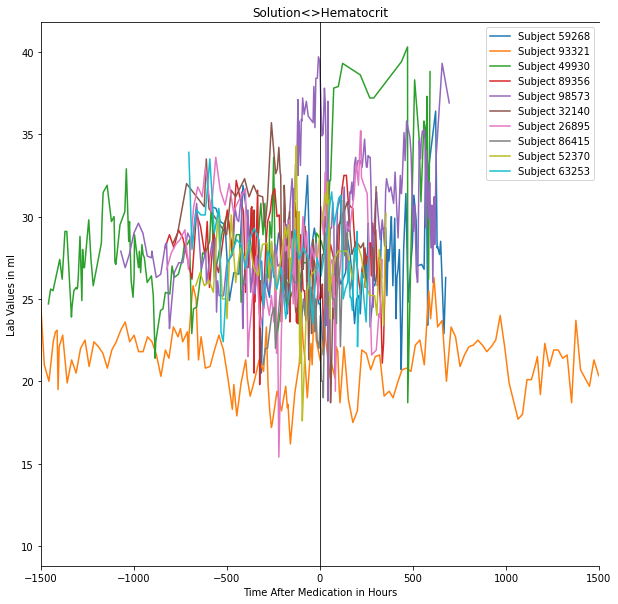

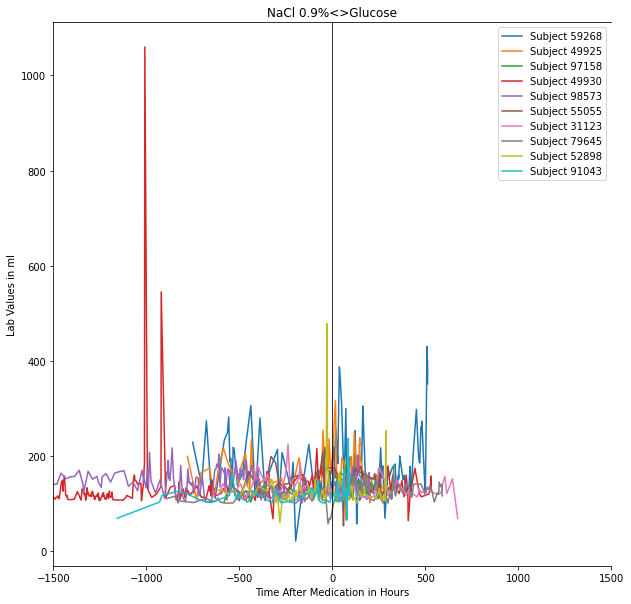

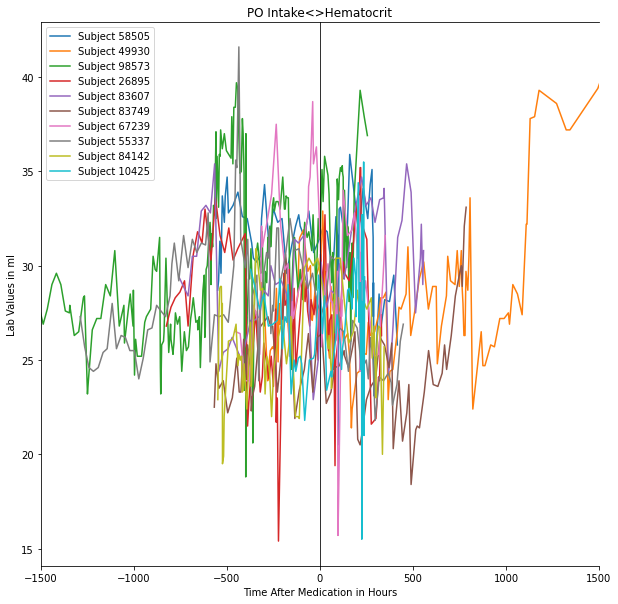

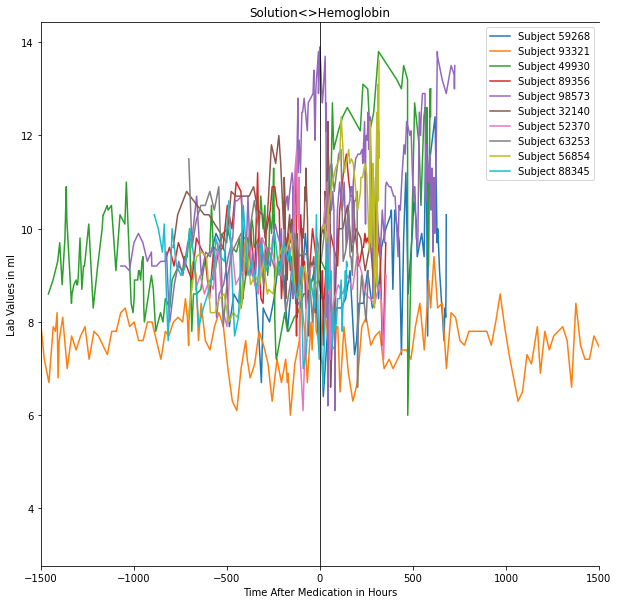

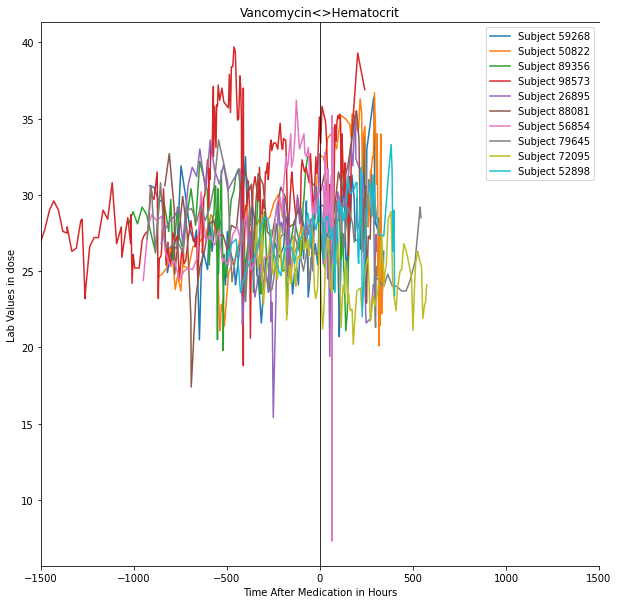

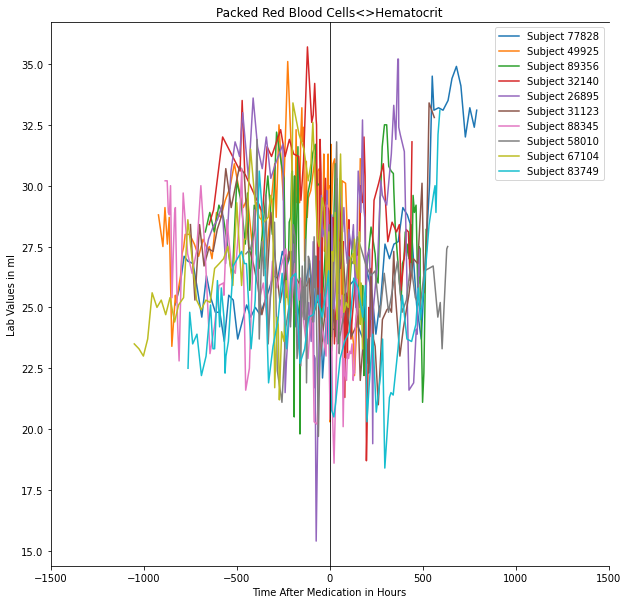

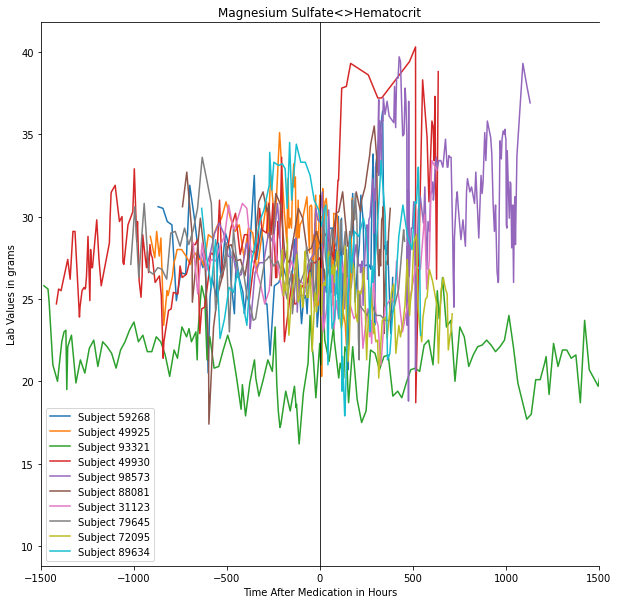

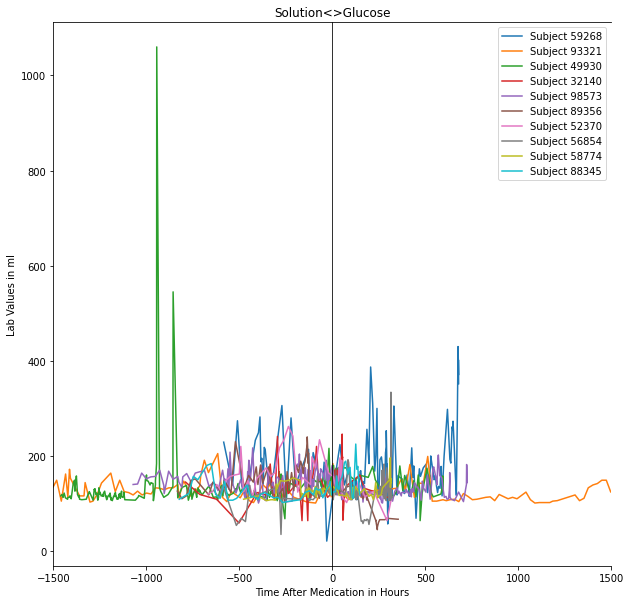

In [ ]:
res = generate_final_plot_data(significant_pairs, 10)
plot_med_lab_pairs(res)

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


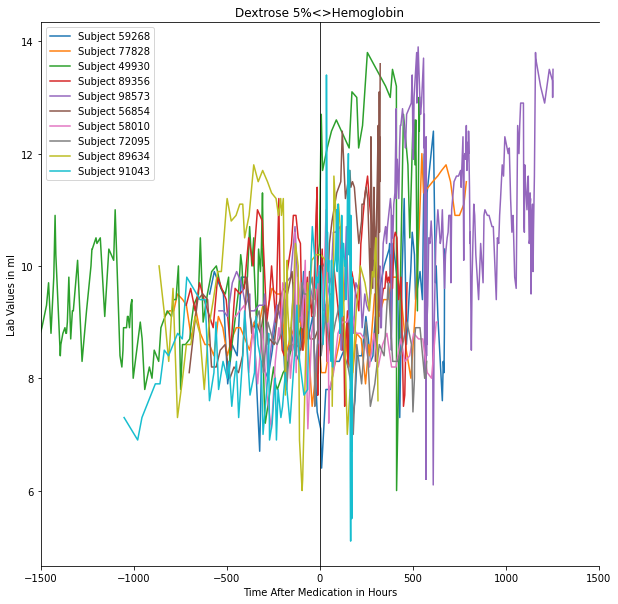

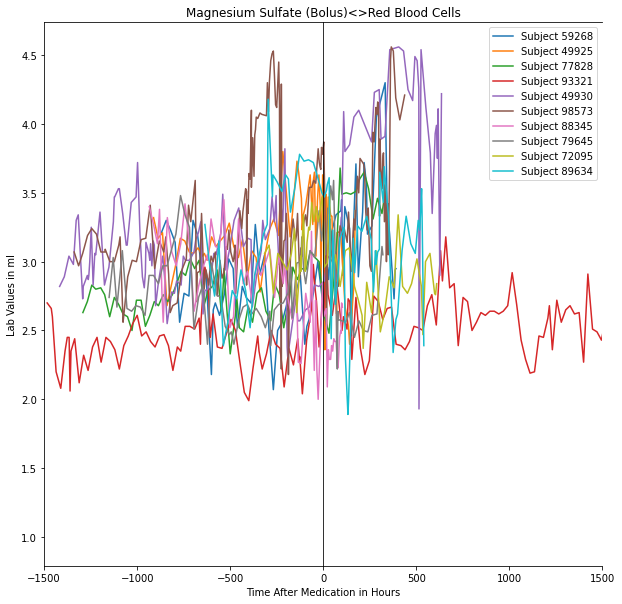

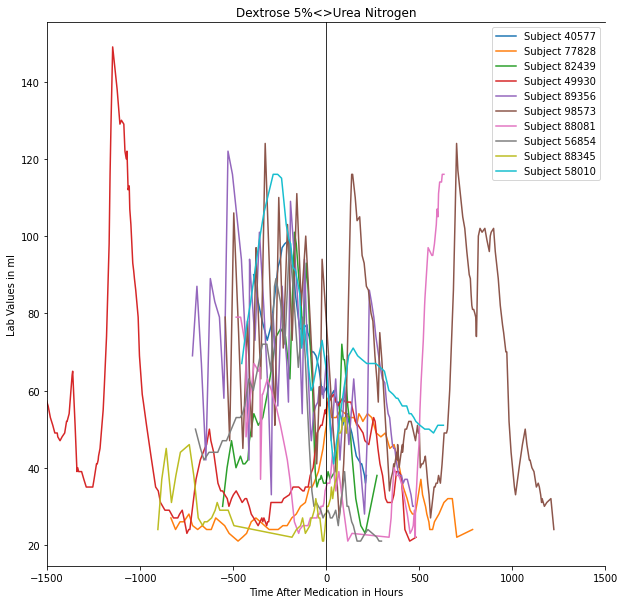

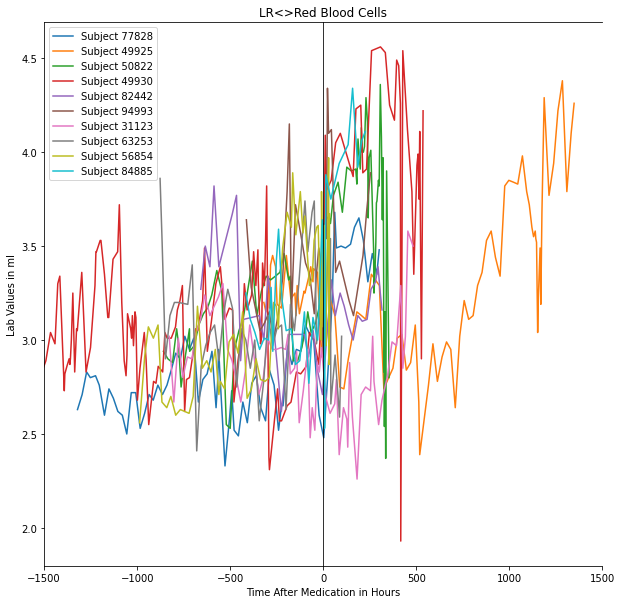

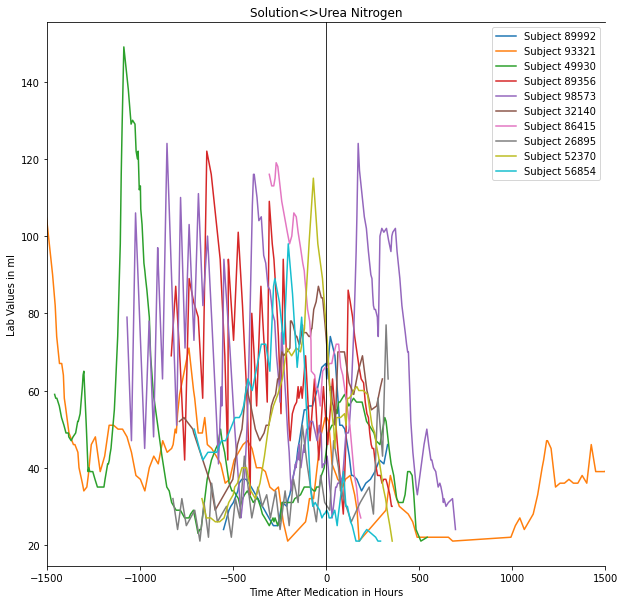

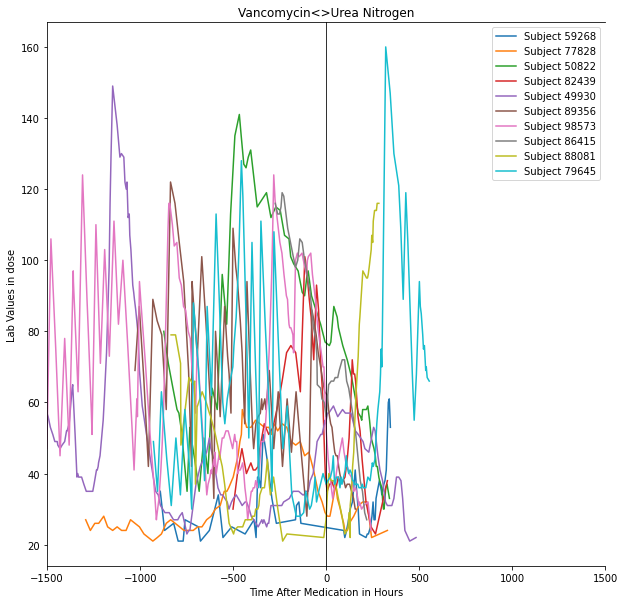

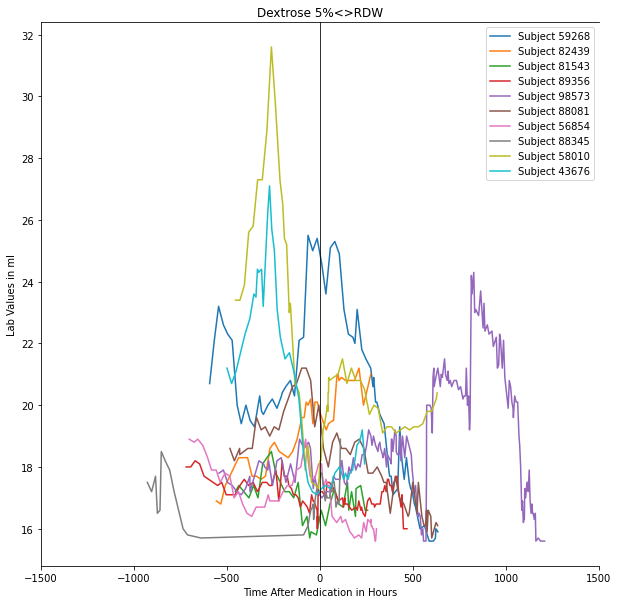

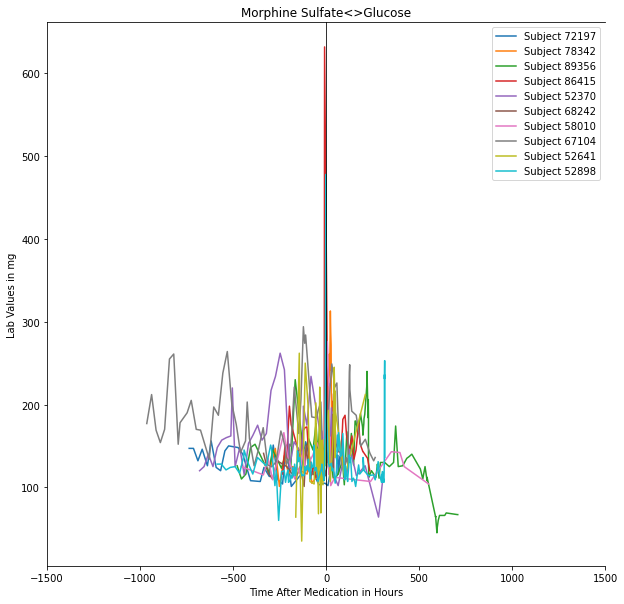

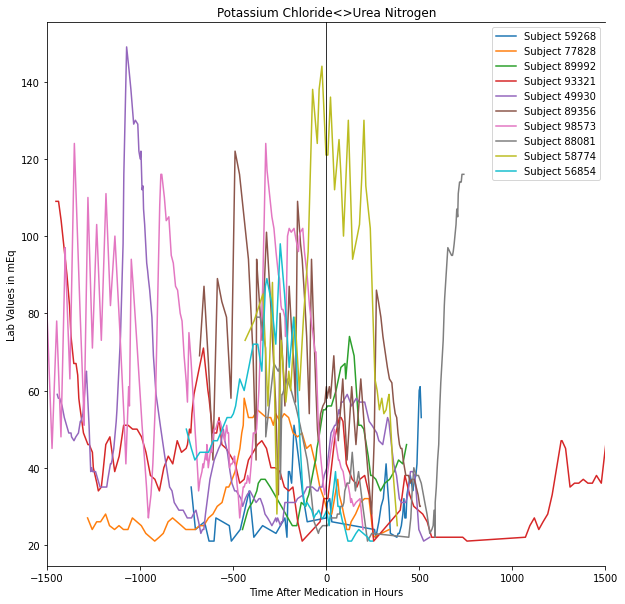

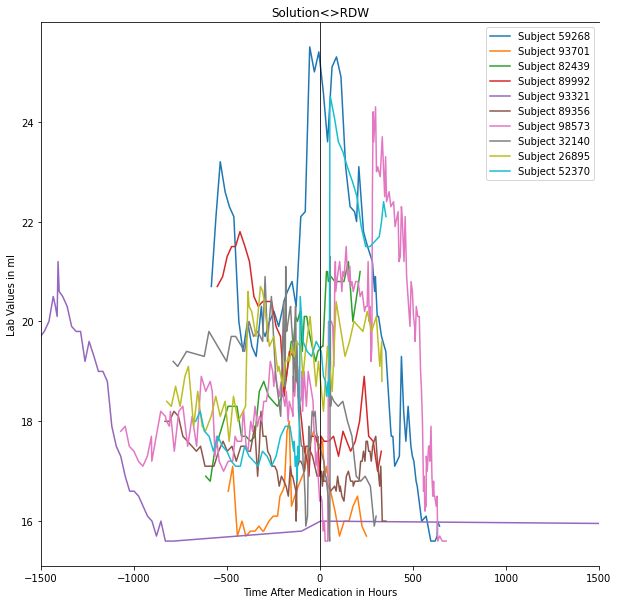

In [ ]:
nres = generate_final_plot_data(non_significant_pairs, 10)
plot_med_lab_pairs(nres)

## Trend Analysis

In [188]:
def trend_analysis(lab_measurements, top200_meds, n_medlab_pairs = 25, n_meds=None):
    uniqueLabTests = lab_measurements.LABEL.unique()
    final_res = []
    after_vals = []

    for i, med in enumerate(top200_meds['MED']): 
        if n_meds is not None and i>=n_meds:
            break
        print(i, ' MED: ', med)
        for j in tqdm(range(uniqueLabTests.shape[0])):
            labTest = uniqueLabTests[j]
            drug_lab, before, after = labpairing(med, patient_presc, lab_measurements, labTest)
            subjects = before['SUBJECT_ID'].unique()
            if(len(before) > n_medlab_pairs):
                before_reg_anal_res, before_lab_vals, before_time = gen_estimate_coef(subjects, before)
                after_reg_anal_res, after_lab_vals, after_time = gen_estimate_coef(subjects, after)
                before_values = np.array(pd.DataFrame(before_reg_anal_res)['coef'])
                after_values = np.array(pd.DataFrame(after_reg_anal_res)['coef'])
                ttest_res = stats.ttest_ind(before_values, after_values)[1]
                final_res.append([med, labTest, ttest_res, np.mean(before_values), np.mean(after_values), len(before)])
    return pd.DataFrame(final_res, columns=['Medication','Lab Test','Number of patients','Before','After','Ttest-pvalue'])

In [189]:
final_trend_res = trend_analysis(lab_measurements, top200_meds, n_medlab_pairs = 1000, n_meds=60)

0  MED:  Dextrose 5%


100%|██████████| 163/163 [04:14<00:00,  1.56s/it]


1  MED:  NaCl 0.9%


100%|██████████| 163/163 [04:02<00:00,  1.49s/it]


2  MED:  PO Intake


100%|██████████| 163/163 [03:00<00:00,  1.11s/it]


3  MED:  Gastric Meds


100%|██████████| 163/163 [02:08<00:00,  1.27it/s]


4  MED:  Solution


100%|██████████| 163/163 [02:54<00:00,  1.07s/it]


5  MED:  Heparin Sodium (Prophylaxis)


100%|██████████| 163/163 [02:29<00:00,  1.09it/s]


6  MED:  Fentanyl


100%|██████████| 163/163 [02:02<00:00,  1.33it/s]


7  MED:  Insulin - Regular


100%|██████████| 163/163 [02:17<00:00,  1.18it/s]


8  MED:  Potassium Chloride


100%|██████████| 163/163 [02:42<00:00,  1.00it/s]


9  MED:  GT Flush


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


10  MED:  Propofol


100%|██████████| 163/163 [01:56<00:00,  1.40it/s]


11  MED:  Vancomycin


100%|██████████| 163/163 [02:40<00:00,  1.01it/s]


12  MED:  Morphine Sulfate


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


13  MED:  KCL (Bolus)


100%|██████████| 163/163 [02:03<00:00,  1.32it/s]


14  MED:  Midazolam (Versed)


100%|██████████| 163/163 [01:31<00:00,  1.78it/s]


15  MED:  Metoprolol


100%|██████████| 163/163 [01:35<00:00,  1.71it/s]


16  MED:  Piggyback


100%|██████████| 163/163 [02:15<00:00,  1.20it/s]


17  MED:  Hydromorphone (Dilaudid)


100%|██████████| 163/163 [00:59<00:00,  2.72it/s]


18  MED:  Insulin - Humalog


100%|██████████| 163/163 [01:13<00:00,  2.23it/s]


19  MED:  Furosemide (Lasix)


100%|██████████| 163/163 [02:12<00:00,  1.23it/s]


20  MED:  LR


100%|██████████| 163/163 [01:58<00:00,  1.37it/s]


21  MED:  Piperacillin/Tazobactam (Zosyn)


100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


22  MED:  Magnesium Sulfate


100%|██████████| 163/163 [02:39<00:00,  1.02it/s]


23  MED:  Pantoprazole (Protonix)


100%|██████████| 163/163 [01:52<00:00,  1.45it/s]


24  MED:  Packed Red Blood Cells


100%|██████████| 163/163 [02:04<00:00,  1.31it/s]


25  MED:  Metronidazole


100%|██████████| 163/163 [01:05<00:00,  2.48it/s]


26  MED:  Famotidine (Pepcid)


100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


27  MED:  Calcium Gluconate


100%|██████████| 163/163 [02:18<00:00,  1.17it/s]


28  MED:  Free Water


100%|██████████| 163/163 [00:49<00:00,  3.29it/s]


29  MED:  Sterile Water


100%|██████████| 163/163 [01:05<00:00,  2.50it/s]


30  MED:  Magnesium Sulfate (Bolus)


100%|██████████| 163/163 [02:18<00:00,  1.18it/s]


31  MED:  Lorazepam (Ativan)


100%|██████████| 163/163 [00:57<00:00,  2.81it/s]


32  MED:  Meropenem


100%|██████████| 163/163 [00:36<00:00,  4.48it/s]


33  MED:  Cefepime


100%|██████████| 163/163 [01:01<00:00,  2.66it/s]


34  MED:  Cefazolin


100%|██████████| 163/163 [00:53<00:00,  3.04it/s]


35  MED:  Hydralazine


100%|██████████| 163/163 [00:55<00:00,  2.92it/s]


36  MED:  Ciprofloxacin


100%|██████████| 163/163 [00:57<00:00,  2.86it/s]


37  MED:  Replete with Fiber (Full)


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


38  MED:  Albumin 25%


100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


39  MED:  KCl (CRRT)


100%|██████████| 163/163 [00:22<00:00,  7.12it/s]


40  MED:  Insulin - Glargine


100%|██████████| 163/163 [00:51<00:00,  3.19it/s]


41  MED:  Norepinephrine


100%|██████████| 163/163 [00:56<00:00,  2.87it/s]


42  MED:  Phenylephrine


100%|██████████| 163/163 [00:50<00:00,  3.23it/s]


43  MED:  Heparin Sodium


100%|██████████| 163/163 [00:53<00:00,  3.07it/s]


44  MED:  Fresh Frozen Plasma


100%|██████████| 163/163 [00:52<00:00,  3.08it/s]


45  MED:  Fentanyl (Concentrate)


100%|██████████| 163/163 [00:50<00:00,  3.23it/s]


46  MED:  OR Crystalloid Intake


100%|██████████| 163/163 [01:38<00:00,  1.66it/s]


47  MED:  Albumin 5%


100%|██████████| 163/163 [01:00<00:00,  2.70it/s]


48  MED:  Nafcillin


100%|██████████| 163/163 [00:15<00:00, 10.44it/s]


49  MED:  Citrate


100%|██████████| 163/163 [00:24<00:00,  6.77it/s]


50  MED:  ACD-A Citrate (1000ml)


100%|██████████| 163/163 [00:22<00:00,  7.27it/s]


51  MED:  D5 1/2NS


100%|██████████| 163/163 [00:48<00:00,  3.33it/s]


52  MED:  Pre-Admission Intake


100%|██████████| 163/163 [00:42<00:00,  3.84it/s]


53  MED:  Haloperidol (Haldol)


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


54  MED:  Dilantin


100%|██████████| 163/163 [00:21<00:00,  7.66it/s]


55  MED:  Piperacillin


100%|██████████| 163/163 [00:41<00:00,  3.88it/s]


56  MED:  Acyclovir


100%|██████████| 163/163 [00:21<00:00,  7.64it/s]


57  MED:  Beneprotein


100%|██████████| 163/163 [00:23<00:00,  7.00it/s]


58  MED:  Ceftriaxone


100%|██████████| 163/163 [00:39<00:00,  4.13it/s]


59  MED:  Labetalol


100%|██████████| 163/163 [00:23<00:00,  7.07it/s]


In [190]:
final_trend_res

,Medication,Lab Test,Number of patients,Before,After,Ttest-pvalue
0,Dextrose 5%,"Calcium, Total",0.764929,0.000097,0.000062,6377
1,Dextrose 5%,Chloride,0.000092,-0.000469,0.000938,3660
2,Dextrose 5%,Creatinine,0.291837,-0.000033,-0.000065,7686
3,Dextrose 5%,Phosphate,0.000959,0.000130,-0.000183,3854
4,Dextrose 5%,Asparate Aminotransferase (AST),0.258556,0.040021,-0.028057,1976
...,...,...,...,...,...,...
1160,Ceftriaxone,pO2,0.690302,0.234302,0.414664,1267
1161,Labetalol,Glucose,0.280907,-0.001809,-0.027113,1631
1162,Labetalol,Hematocrit,0.000016,0.000071,-0.001103,1876
1163,Labetalol,Hemoglobin,0.000043,-0.000001,-0.000426,1739


In [192]:
final_trend_res.to_csv(os.path.join(RESULT, 'Medication', 'Trend',  'Med-Labtest_Pairs_trend_analysis_Top60meds.csv'))